In [1]:
import sys
sys.path.append('/lmh_data/work/sclab/train/')

import numpy as np
import pandas as pd
import torch
import torch.utils.data as data
from torch.autograd import Variable
from captum.attr import IntegratedGradients

from dataset import Dataset
from net import define_network

In [2]:
torch.manual_seed(123)
np.random.seed(123)

In [3]:
def evaluate(eval_file, model_file, gene_name):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()
    ig = IntegratedGradients(model)

    _datas = np.load(eval_file, allow_pickle=True)
    important_genes = dict(Astro=dict(), Endo=dict(), OPC=dict(), ODC=dict())
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'Astro':
            continue
        _important_genes = important_genes[_datas[index-1]['cell_type']]
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1) / 10
        
        attributions = torch.zeros(input.reshape(-1).shape).cuda()
        for i in range(target.shape[-1]):
            attributions += ig.attribute(input, target=(0, i))[0, 0].reshape(-1)
        attributions = attributions.cpu().detach().numpy()
        for i in range(len(attributions)):
            if i not in _important_genes.keys():
                _important_genes[i] = 0
            _important_genes[i] += attributions[i]
        
    return important_genes

important_genes = evaluate(
    '/lmh_data/data/sclab/sclab/eval_dataset.npy',
    '/lmh_data/data/sclab/sclab/tmp/GPM6A/model_epoch_12.pth', 'GPM6A')
important_genes

{'Astro': {0: 0.0,
  1: 0.0,
  2: 0.0,
  3: 0.0,
  4: 0.0,
  5: 0.0,
  6: 0.0,
  7: 0.0,
  8: 0.0,
  9: 0.0,
  10: 0.0,
  11: 0.0,
  12: 0.0,
  13: 0.0,
  14: 0.0,
  15: 0.0,
  16: 0.0,
  17: 0.0,
  18: 0.12261380814015865,
  19: -0.07864655088633299,
  20: -0.03791014477610588,
  21: 0.0,
  22: -0.06334626115858555,
  23: 0.011273164302110672,
  24: -0.1754994448274374,
  25: 0.0,
  26: 0.048089302610605955,
  27: 0.0,
  28: 0.0,
  29: 0.0,
  30: 0.0,
  31: 0.0,
  32: 0.0,
  33: 0.0,
  34: -0.060293751768767834,
  35: 0.0,
  36: 0.0,
  37: -0.01679467037320137,
  38: -0.04993229918181896,
  39: 0.0074301305576227605,
  40: 0.0,
  41: 0.03295679623261094,
  42: 0.0,
  43: -0.07196377776563168,
  44: -0.03140313923358917,
  45: -0.22843753919005394,
  46: -0.1757498374208808,
  47: -0.1410309560596943,
  48: 0.0,
  49: 0.0,
  50: 0.01476171612739563,
  51: 0.0,
  52: 0.200054120272398,
  53: 0.046038366854190826,
  54: -0.026211800053715706,
  55: -0.11148561909794807,
  56: 0.0,
  57: 

In [4]:
scRNA_head = np.load('/lmh_data/data/sclab/sclab/eval_dataset.npy', allow_pickle=True)[0]['scRNA_head']

def find_special_genes(important_genes, cell_type):
    genes = pd.DataFrame(
        sorted(important_genes[cell_type].items(), key=lambda x: x[1], reverse=True), columns=['index', 'value']
    ).set_index('index')
    genes = genes.sort_values(by=['value'], ascending=False)
    return genes

genes = find_special_genes(important_genes, 'Astro')
genes['name'] = scRNA_head[list(genes.index)]
genes.to_csv('tmp/related_genes_GPM6A.csv')
genes

,value,name
index,,
15794,215.840745,MALAT1
5505,79.062234,LSAMP
18428,70.996343,PCDH9
7265,70.632543,GPM6A
15264,62.720887,SLC1A2
...,...,...
10727,-23.603608,GRM3
23067,-24.527976,MSI2
14604,-26.260437,ABLIM1


In [5]:
genes = genes[:100]
gene_names = genes.name.values
gene_names

array(['MALAT1', 'LSAMP', 'PCDH9', 'GPM6A', 'SLC1A2', 'NRXN1', 'SPARCL1',
       'FBXL7', 'XIST', 'ZBTB20', 'MAPK10', 'PITPNC1', 'ERBB4', 'NPAS3',
       'CST3', 'TRPM3', 'NRG3', 'NTRK2', 'ANK2', 'DST', 'CADM2', 'DPP10',
       'CTNND2', 'HSPA1A', 'NKAIN3', 'NTM', 'RORA', 'FTX', 'ARHGAP24',
       'CLU', 'SLC1A3', 'AQP4', 'CADM1', 'LINC00299', 'TMEM108', 'NFIA',
       'PTPRG', 'FGFR3', 'GPC5', 'TCF4', 'PTPRZ1', 'FAM171B', 'DOCK4',
       'PTK2', 'NAV3', 'NFIB', 'FTH1', 'CHL1', 'AHCYL2', 'BMPR1B',
       'PPAP2B', 'RYR3', 'CRB1', 'MEIS2', 'APOE', 'ZFHX4', 'PHF14',
       'WIF1', 'PRTFDC1', 'CALM2', 'CPE', 'ZSWIM6', 'NAV2', 'MED13L',
       'PSD3', 'GLUL', 'PDE4B', 'GAREM', 'SLC7A11', 'N4BP2L2', 'CAMTA1',
       'PPP1R3C', 'RGS7', 'TNIK', 'PON2', 'PRKG1', 'GFAP', 'UBR5',
       'LRRC16A', 'ACSL6', 'RFX3', 'PAMR1', 'ATP2C1', 'PREX2', 'MAGI2',
       'MID1', 'SYNE1', 'GMDS-AS1', 'ARHGEF4', 'LIFR', 'LUC7L3', 'ZHX3',
       'PHLPP1', 'FAF1', 'MACROD2', 'FAM171A1', 'PCDH7', 'JMJD1C',
       

In [6]:
literome = pd.read_csv('/lmh_data/data/sclab/source/literome/pathway-extraction.txt', sep='\t')

def get_filter(gene_name, num=0):
    if num == 2:
        return pd.DataFrame()
    _filter_Causes = literome[literome.Theme.str.contains(gene_name)].Cause.str.split(':').str[-1].str.split('_')
    _filter_Themes = literome[literome.Cause.str.contains(gene_name)].Theme.str.split(':').str[-1].str.split('_')
    _filter_genes = set()
    for _filter in pd.concat([_filter_Causes, _filter_Themes]).values:
        _filter_genes = _filter_genes | set(_filter)
    _filters = [get_filter(_name, num+1) for _name in _filter_genes]
    _filters.append(_filter_Causes)
    _filters.append(_filter_Themes)
    return pd.concat(_filters)

_filters = get_filter('GPM6A')

In [7]:
_filter_genes = set()
for _filter in _filters.values:
    _filter_genes = _filter_genes | set(_filter[0])
print(len(_filter_genes & set(gene_names)) / len(gene_names))
_filter_genes & set(gene_names)

0.2


{'APOE',
 'ARHGEF4',
 'CALM2',
 'CPE',
 'CST3',
 'DST',
 'FGFR3',
 'GFAP',
 'GLUL',
 'GPC5',
 'GPM6A',
 'LIFR',
 'MAPK10',
 'NFIB',
 'NTRK2',
 'PHF14',
 'PPP1R3C',
 'PTK2',
 'RYR3',
 'TCF4'}

In [8]:
_filter_genes

{'NMU',
 'MBL2',
 'NCOA5',
 '29676|28950|22191|28960|28961|19955|28969|28983|28984|28991|28992|19956|21580|29016|29020|19958|21636|29562|29058|29068|19960|29110|29111|28532|22206|29145|29146|1314|29154|21107|29172|29174|29180|29192|26953|29198|29472|19918|29209|29213|29218|29219|25428|29229|21213|29231|23419|29618|29248|29264|29272|24500|29276|17686|26725|29283|29288|29289|29301|29302|22219|25559|21360|29319|29327|29335|29345|29350|21610|29366|20365|29368|29372|29387|26959|21053|23427|28236|28513|30494|29433|23378',
 'DPH6',
 'LY96',
 'TYRP1',
 'COPA',
 'PRKCB',
 'GABRB2',
 'KDM5B',
 'MMP17',
 'NFKBIA',
 'DDX24',
 'STK3',
 'DCTN2',
 'CD46',
 'PART1',
 'MUC16',
 'CTDP1',
 'PIRC33',
 'MC2R',
 'PBX1',
 'PIRC103',
 'IDDM2',
 'CTSC',
 'RPL14',
 'RNASE7',
 'PIRC34',
 'AHR',
 'DHX9',
 'BAI1',
 'RNASE10',
 'STX4',
 'PDCD2',
 'FGF8',
 '7626|7627',
 'ROR1',
 'PIRC76',
 'DDX5',
 'IDDM7',
 'SETD2',
 'PLD2',
 'TLR8',
 'CUL2',
 'DDX52',
 'PIRC104',
 'HSPE1',
 'RBX1',
 'PBX4',
 'NMB',
 'SSTR3',
 'EPH

In [9]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(eval_file, model_file, gene_name, ignore_genes_index):
    eval_set = Dataset(eval_file, gene_name, is_train=True)
    data_loader = data.DataLoader(eval_set, batch_size=1, shuffle=False)

    input_size, output_size = tuple(eval_set[0][0].shape), eval_set[0][1].shape[0]
    patch_size = tuple([int(i / 8) for i in input_size])
    model = torch.nn.DataParallel(define_network(input_size, patch_size, output_size))
    model.load_state_dict(torch.load(model_file))
    model.cuda()
    model.eval()

    _datas = np.load(eval_file, allow_pickle=True)
    pearsons = []
    for index, batch in enumerate(data_loader, 1):
        if _datas[index-1]['cell_type'] != 'Astro':
            continue
        input = Variable(batch[0]).cuda().unsqueeze(1)
        target = Variable(batch[1]).cuda().unsqueeze(1).cpu().numpy()
        
        _shape = input.shape
        input = input.reshape(-1)
        input[ignore_genes_index] = 0
        input = input.reshape(_shape)
        output = model(input).detach().cpu().numpy()
        
        pearson = stats.pearsonr(output[0, 0], target[0, 0])[0]
        pearsons.append(pearson)
        
    return pearsons

In [10]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/tmp/GPM6A/model_epoch_12.pth', 'GPM6A', list(genes.index)[:i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

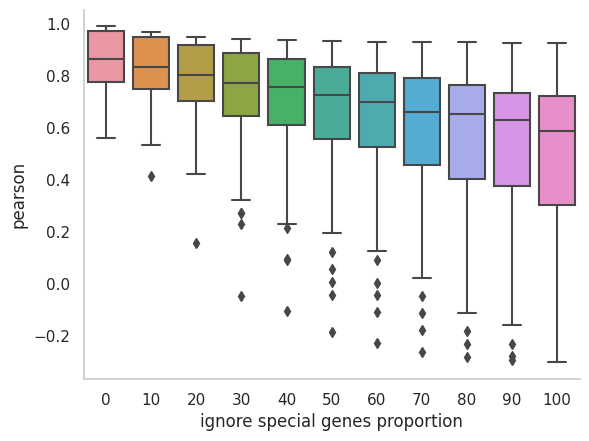

In [11]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

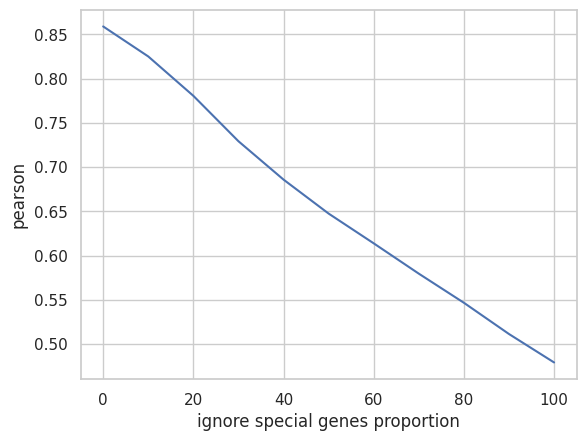

In [12]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

In [13]:
ignore_preds_info = []
for i in range(0, 101, 10):
    pearsons = evaluate(
        '/lmh_data/data/sclab/sclab/eval_dataset.npy',
        '/lmh_data/data/sclab/sclab/tmp/GPM6A/model_epoch_12.pth', 'GPM6A', list(genes.index)[max(i-10, 0):i])
    _df = pd.DataFrame({'pearson': pearsons, 'ignore proportion': i})
    ignore_preds_info.append(_df)

ignore_preds_info = pd.concat(ignore_preds_info, axis=0, ignore_index=True)

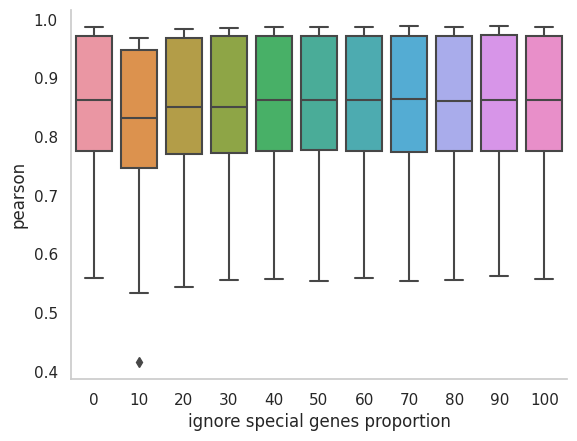

In [14]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(
    x='ignore proportion', y='pearson', data=ignore_preds_info
)

sns.despine()
plt.grid(False)

plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

plt.show()

Text(0, 0.5, 'pearson')

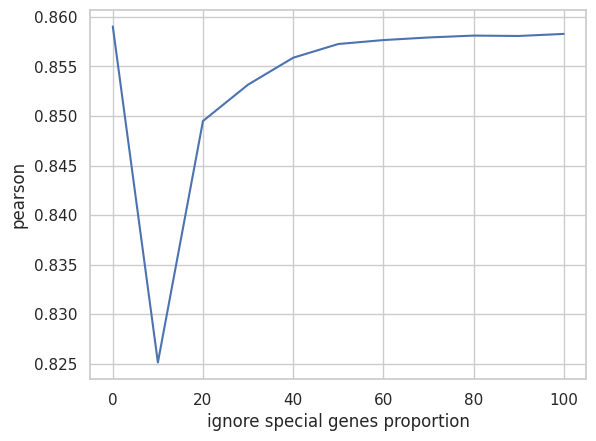

In [15]:
_group_by = ignore_preds_info.groupby('ignore proportion').mean()
x, y = _group_by.index, _group_by.values.flatten()
plt.plot(x, y)
plt.xlabel("ignore special genes proportion")
plt.ylabel("pearson")

In [ ]:
y = genes.value.values.flatten()

x = [i for i in range(len(y))]
plt.plot(x, y)